In [1]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 62.7 MB/s eta 0:00:00


In [2]:


from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import Pauli
from qiskit.primitives import Estimator



class quantum_layer:
    def __init__(self,nbqbitin,nbqbitout,name):
        self.nbqbitin = nbqbitin
        self.nbqbitout = nbqbitout

        self.circuit = self.create_circuit(4,name=name)
    def create_circuit(self,nbqbits=4,name=None):
        def conv_circuit(params):
            target = QuantumCircuit(2)
            target.rz(-np.pi / 2, 1)
            target.cx(1, 0)
            target.rz(params[0], 0)
            target.ry(params[1], 1)
            target.cx(0, 1)
            target.ry(params[2], 1)
            target.cx(1, 0)
            target.rz(np.pi / 2, 0)
            return target

        def conv_layer(num_qubits, param_prefix):
            qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
            qubits = list(range(num_qubits))
            param_index = 0
            params = ParameterVector(param_prefix, length=num_qubits * 3)
            for q1, q2 in zip(qubits[0::2], qubits[1::2]):
                qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
                qc.barrier()
                param_index += 3
            for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
                qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
                qc.barrier()
                param_index += 3

            qc_inst = qc.to_instruction()

            qc = QuantumCircuit(num_qubits)
            qc.append(qc_inst, qubits)
            return qc

        def pool_circuit(params):
            target = QuantumCircuit(2)
            target.rz(-np.pi / 2, 1)
            target.cx(1, 0)
            target.rz(params[0], 0)
            target.ry(params[1], 1)
            target.cx(0, 1)
            target.ry(params[2], 1)

            return target

        def pool_layer(sources, sinks, param_prefix):
            num_qubits = len(sources) + len(sinks)
            qc = QuantumCircuit(num_qubits, name="Pooling Layer")
            param_index = 0
            params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
            for source, sink in zip(sources, sinks):
                qc = qc.compose(pool_circuit(params[param_index: (param_index + 3)]), [source, sink])
                qc.barrier()
                param_index += 3

            qc_inst = qc.to_instruction()

            qc = QuantumCircuit(num_qubits)
            qc.append(qc_inst, range(num_qubits))
            return qc

        feature_map = ZFeatureMap(nbqbits)

        ansatz = QuantumCircuit(nbqbits, name="Ansatz")

        # First Convolutional Layer
        # ansatz.compose(conv_layer(nbqbits, "c1"), list(range(nbqbits)), inplace=True)
        #
        # # First Pooling Layer
        # ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

        # Second Convolutional Layer
        ansatz.compose(conv_layer(4, name+"c2"), list(range(0, 4)), inplace=True)

        # Second Pooling Layer
        #ansatz.compose(pool_layer([0, 1], [2, 3], name+"p2"), list(range(0, 4)), inplace=True)

        # Third Convolutional Layer




        # Combining the feature map and ansatz
        circuit = QuantumCircuit(4)
        circuit.compose(feature_map, range(4), inplace=True)
        circuit.compose(ansatz, range(4), inplace=True)
        circuit.x(list(range(4)))

        observable = [Pauli('I' * i + 'Z' + 'I' * (4  - i - 1)) for i in range(4)]


        backend_options = {'method': 'statevector', 'max_parallel_threads': 1}
        backend = AerSimulator(**backend_options)
        print(backend.status)
        circuit = transpile(circuit, backend=backend, optimization_level=3)

        # we decompose the circuit for the QNN to avoid additional data copying
        estimator = Estimator()
        qnn = EstimatorQNN(
        circuit=circuit.decompose(),
        observables=observable,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        estimator=estimator  # Ajout du nouvel estimator V2
        )
        return qnn


def create_quantum_layer(nbqbitin,nbqbitout,name):
    return quantum_layer(nbqbitin,nbqbitout,name)

In [4]:
from qiskit.circuit import ParameterVector
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import qiskit
from qiskit_machine_learning.connectors import TorchConnector
torch.set_num_threads(1)
import time
from google.colab import drive
from torch.utils.data import Subset

class CVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=2):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + num_classes, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, 4)
        self.fc_logvar = nn.Linear(400, 4)

        self.quantom_layer_mu = TorchConnector(create_quantum_layer(4,2,name="mu").circuit)
        self.quantom_layer_logvar = TorchConnector(create_quantum_layer(4,2,name="logvar").circuit)

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = torch.cat([x, c], dim=1)

        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)




        mu = self.quantom_layer_mu(mu)
        logvar = self.quantom_layer_logvar(logvar)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

Mounted at /content/drive


In [ ]:




# Modèle CVAE

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Chargement des données MNIST
subset_size = 5000
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
filtered_data = [(data, label) for data, label in mnist_data if label in [0, 1]]
indices = torch.randperm(len(filtered_data))[:subset_size]
subset_data = Subset(filtered_data, indices)
data_loader = DataLoader(subset_data, batch_size=8, shuffle=True)

# Initialisation du modèle et de l'optimiseur
latent_dim = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvae = CVAE(latent_dim).to(device)
#cvae.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/QCVAE.pth'))
optimizer = optim.Adam(cvae.parameters(), lr=1e-3,betas=(0.5, 0.999))



cvae.train()
# Entraînement
num_epochs = 10
temps_debut = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(data_loader):
        print("new batch")
        data = data.to(device).view(-1, 28 * 28)
        labels_one_hot = torch.nn.functional.one_hot(labels, cvae.num_classes).float().to(device)  # Encodage one-hot des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels_one_hot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if (time.time()-temps_debut)%600<5:
          torch.save(cvae.state_dict(),"/content/drive/My Drive/Colab Notebooks/QCVAE.pth")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(data_loader.dataset):.4f}')




<bound method AerBackend.status of AerSimulator('aer_simulator_statevector')>


<ipython-input-7-700d74a38b9b>:115: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-7-700d74a38b9b>:116: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


<bound method AerBackend.status of AerSimulator('aer_simulator_statevector')>


<ipython-input-7-700d74a38b9b>:115: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-7-700d74a38b9b>:116: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch
new batch


<bound method AerBackend.status of AerSimulator('aer_simulator_statevector')>
<bound method AerBackend.status of AerSimulator('aer_simulator_statevector')>


<ipython-input-2-c34d016e999a>:115: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-2-c34d016e999a>:116: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
<ipython-input-2-c34d016e999a>:115: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterp

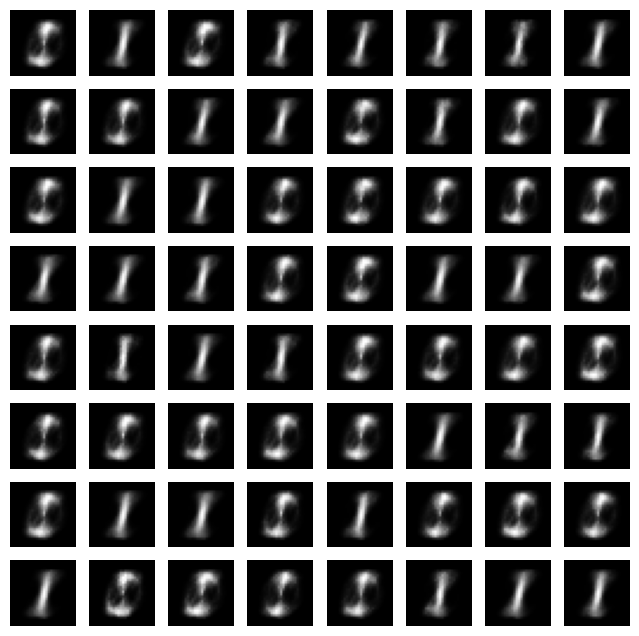

In [5]:
# Génération conditionnelle d'un "5"
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CVAE(latent_dim=latent_dim)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/QCVAE.pth'))
model.eval()
with torch.no_grad():
    # Vecteur latent aléatoire
    z = torch.randn(64, latent_dim).to(device)

    # Condition : Générer un "5"
    condition = torch.zeros(64, 2).to(device)
    condition[:, 1] = 1  # Encode le chiffre 5 en one-hot
    for i in range(condition.shape[0]):  # Iterate over each row (vector)
      condition[i, torch.randint(0, 2, (1,))] = 1 # Assign a random digit for each row


    generated_images = model.decode(z, condition).cpu().view(-1, 1, 28, 28)

    # Affichage des images générées
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()